In [13]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import seaborn as sns

In [14]:
# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download BTC crypto data from Yahoo Finance using ticker 'BTC-USD'
ticker = 'BTC-USD'
data_btc = yf.download(tickers=ticker, start=start_date, end=end_date)
df_btc = pd.DataFrame(data_btc)
df_btc.reset_index(inplace=True)
df_btc.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_btc['Gold_Adj_Close'] = df_gold['Adj Close']
df_btc['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_btc = df_btc.ffill()

df_btc


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
Date,,,,,,,,
2021-04-14,63523.753906,64863.097656,61554.796875,63109.695312,63109.695312,77451779687,1734.900024,91.690002
2021-04-15,63075.195312,63821.671875,62208.964844,63314.011719,63314.011719,60954381579,1765.400024,91.669998
2021-04-16,63258.503906,63594.722656,60222.531250,61572.789062,61572.789062,84293007468,1779.000000,91.559998
2021-04-17,61529.921875,62572.175781,60361.351562,60683.820312,60683.820312,66138759198,1779.000000,91.559998
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,1779.000000,91.559998
...,...,...,...,...,...,...,...,...
2024-06-22,64113.863281,64475.468750,63929.757812,64252.578125,64252.578125,9858198793,2316.399902,105.800003
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802,2316.399902,105.800003
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,60277.414062,43152133651,2330.000000,105.470001


In [15]:
# Check for null values
df_btc.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Gold_Adj_Close       0
USIndex_Adj_Close    0
dtype: int64

In [16]:
# Check for duplicate indices
df_btc.index.duplicated(keep=False).sum()

0

In [17]:
# Stats for data
df_btc.describe()

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
count,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1.170000e+03,1170.000000,1170.000000
mean,37526.673756,38309.514401,36662.296666,37521.365573,37521.365573,2.872757e+10,1907.018373,101.403171
std,15098.615799,15450.761706,14678.399904,15091.156653,15091.156653,1.492200e+10,164.134783,5.544575
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09,1623.300049,89.639999
25%,25923.698730,26227.176758,25644.452637,25921.914551,25921.914551,1.820977e+10,1793.699951,96.290001
50%,35334.187500,36067.121094,34122.207031,35318.984375,35318.984375,2.666069e+10,1872.199951,103.120003
75%,46721.500000,47867.967773,45630.132812,46732.504883,46732.504883,3.542749e+10,1979.500000,104.885000
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,1.263581e+11,2433.899902,114.110001


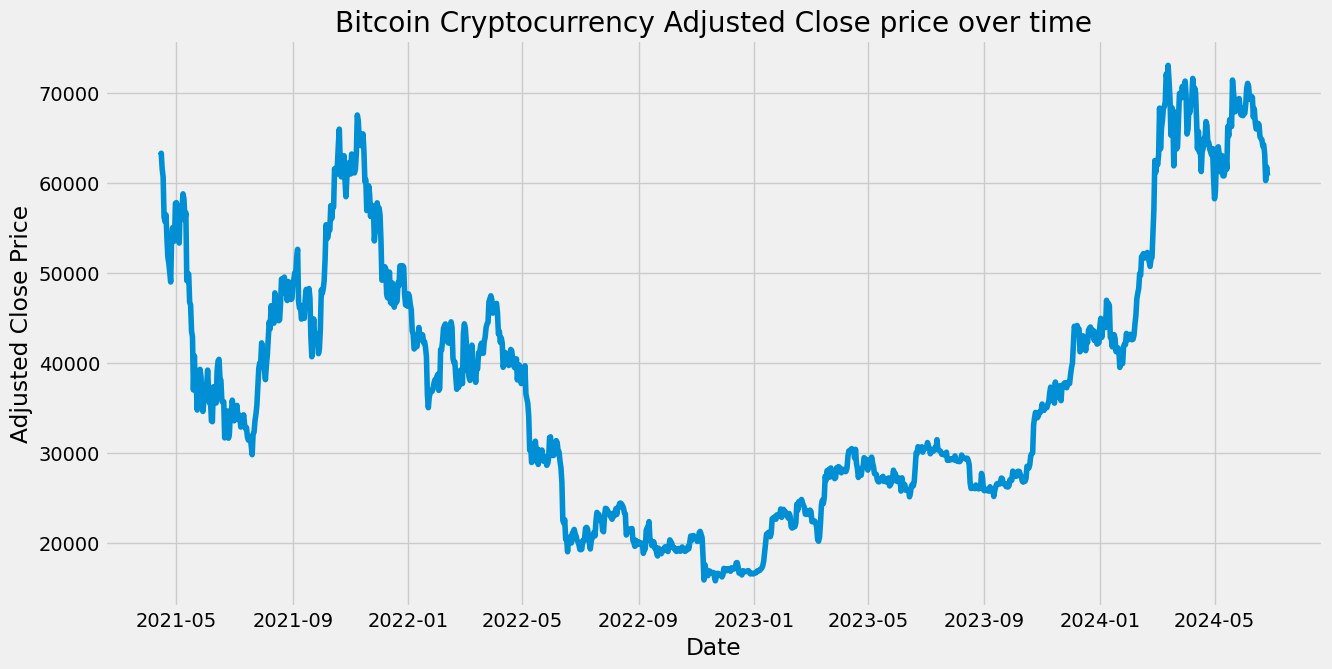

In [18]:
# Theme for plots
plt.style.use('fivethirtyeight')

# Plotting the Adjusted Close price to show the trend

plt.figure(figsize=(14,7))
plt.plot(df_btc.index, df_btc['Adj Close'])
plt.title('Bitcoin Cryptocurrency Adjusted Close price over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()

In [19]:
# Calculate differences between high and low prices for the stock data
df_btc['High_Low_Diff'] = df_btc['High'] - df_btc['Low']

# Calculate percentage returns and log percentage returns
df_btc['Pct_Returns'] = df_btc['Adj Close'].pct_change()
df_btc['Log_Pct_Returns'] = np.log(1 + df_btc['Pct_Returns'])

df_btc['Log_Pct_Returns_1'] = df_btc['Log_Pct_Returns'].shift(1)
df_btc.dropna(inplace=True)
df_btc

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,Log_Pct_Returns,Log_Pct_Returns_1
Date,,,,,,,,,,,,
2021-04-16,63258.503906,63594.722656,60222.531250,61572.789062,61572.789062,84293007468,1779.000000,91.559998,3372.191406,-0.027501,-0.027887,0.003232
2021-04-17,61529.921875,62572.175781,60361.351562,60683.820312,60683.820312,66138759198,1779.000000,91.559998,2210.824219,-0.014438,-0.014543,-0.027887
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,1779.000000,91.559998,8227.921875,-0.073622,-0.076472,-0.014543
2021-04-19,56191.585938,57520.054688,54368.593750,55724.265625,55724.265625,65344865159,1769.400024,91.070000,3151.460938,-0.008750,-0.008789,-0.076472
2021-04-20,55681.792969,57062.148438,53448.046875,56473.031250,56473.031250,67849323955,1777.300049,91.239998,3614.101562,0.013437,0.013348,-0.008789
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-22,64113.863281,64475.468750,63929.757812,64252.578125,64252.578125,9858198793,2316.399902,105.800003,545.710938,0.002440,0.002437,-0.011363
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802,2316.399902,105.800003,1310.906250,-0.016681,-0.016821,0.002437
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,60277.414062,43152133651,2330.000000,105.470001,4690.828125,-0.045954,-0.047043,-0.016821


##### Technical Indicators

In [20]:
# Moving Averages

# Simple Moving Averages
df_btc['SMA_5'] = df_btc['Adj Close'].rolling(window=5).mean()
df_btc['SMA_10'] = df_btc['Adj Close'].rolling(window=10).mean()
df_btc['SMA_20'] = df_btc['Adj Close'].rolling(window=20).mean()
df_btc['SMA_50'] = df_btc['Adj Close'].rolling(window=50).mean()
df_btc['SMA_100'] = df_btc['Adj Close'].rolling(window=100).mean()

# Exponential Moving Averages
df_btc['EMA_50'] = df_btc['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_btc['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_btc['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_btc['MACD'] = df_btc['Adj Close'].ewm(span=12, adjust=False).mean() - df_btc['Adj Close'].ewm(span=26, adjust=False).mean()
df_btc['MACD_Signal'] = df_btc['MACD'].ewm(span=9, adjust=False).mean()
df_btc['MACD_Hist'] = df_btc['MACD'] - df_btc['MACD_Signal']

# Bollinger Bands
df_btc['BB_Upper'] = df_btc['SMA_20'] + 2*df_btc['Adj Close'].rolling(window=20).std()
df_btc['BB_Lower'] = df_btc['SMA_20'] - 2*df_btc['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_btc['14-high'] = df_btc['High'].rolling(14).max()
df_btc['14-low'] = df_btc['Low'].rolling(14).min()
df_btc['%K'] = (df_btc['Adj Close'] - df_btc['14-low']) * 100 / (df_btc['14-high'] - df_btc['14-low'])
df_btc['%D'] = df_btc['%K'].rolling(3).mean()

# Average True Range (ATR)
df_btc['H-L'] = df_btc['High'] - df_btc['Low']
df_btc['H-PC'] = np.abs(df_btc['High'] - df_btc['Adj Close'].shift(1))
df_btc['L-PC'] = np.abs(df_btc['Low'] - df_btc['Adj Close'].shift(1))
df_btc['TR'] = df_btc[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_btc['ATR'] = df_btc['TR'].rolling(14).mean()

df_btc

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,BB_Lower,14-high,14-low,%K,%D,H-L,H-PC,L-PC,TR,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-16,63258.503906,63594.722656,60222.531250,61572.789062,61572.789062,84293007468,1779.000000,91.559998,3372.191406,-0.027501,...,NaN,NaN,NaN,NaN,NaN,3372.191406,NaN,NaN,3372.191406,NaN
2021-04-17,61529.921875,62572.175781,60361.351562,60683.820312,60683.820312,66138759198,1779.000000,91.559998,2210.824219,-0.014438,...,NaN,NaN,NaN,NaN,NaN,2210.824219,999.386719,1211.437500,2210.824219,NaN
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,1779.000000,91.559998,8227.921875,-0.073622,...,NaN,NaN,NaN,NaN,NaN,8227.921875,373.636719,7854.285156,8227.921875,NaN
2021-04-19,56191.585938,57520.054688,54368.593750,55724.265625,55724.265625,65344865159,1769.400024,91.070000,3151.460938,-0.008750,...,NaN,NaN,NaN,NaN,NaN,3151.460938,1303.871094,1847.589844,3151.460938,NaN
2021-04-20,55681.792969,57062.148438,53448.046875,56473.031250,56473.031250,67849323955,1777.300049,91.239998,3614.101562,0.013437,...,NaN,NaN,NaN,NaN,NaN,3614.101562,1337.882812,2276.218750,3614.101562,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-22,64113.863281,64475.468750,63929.757812,64252.578125,64252.578125,9858198793,2316.399902,105.800003,545.710938,0.002440,...,62956.210300,70146.070312,63378.894531,12.910609,11.074939,545.710938,379.269531,166.441406,545.710938,1673.441964
2024-06-23,64248.964844,64491.703125,63180.796875,63180.796875,63180.796875,11170471802,2316.399902,105.800003,1310.906250,-0.016681,...,62332.202250,70146.070312,63180.796875,0.000000,7.836791,1310.906250,239.125000,1071.781250,1310.906250,1720.172433
2024-06-24,63173.351562,63292.527344,58601.699219,60277.414062,60277.414062,43152133651,2330.000000,105.470001,4690.828125,-0.045954,...,61177.911394,69977.890625,58601.699219,14.730016,9.213542,4690.828125,111.730469,4579.097656,4690.828125,1989.970982


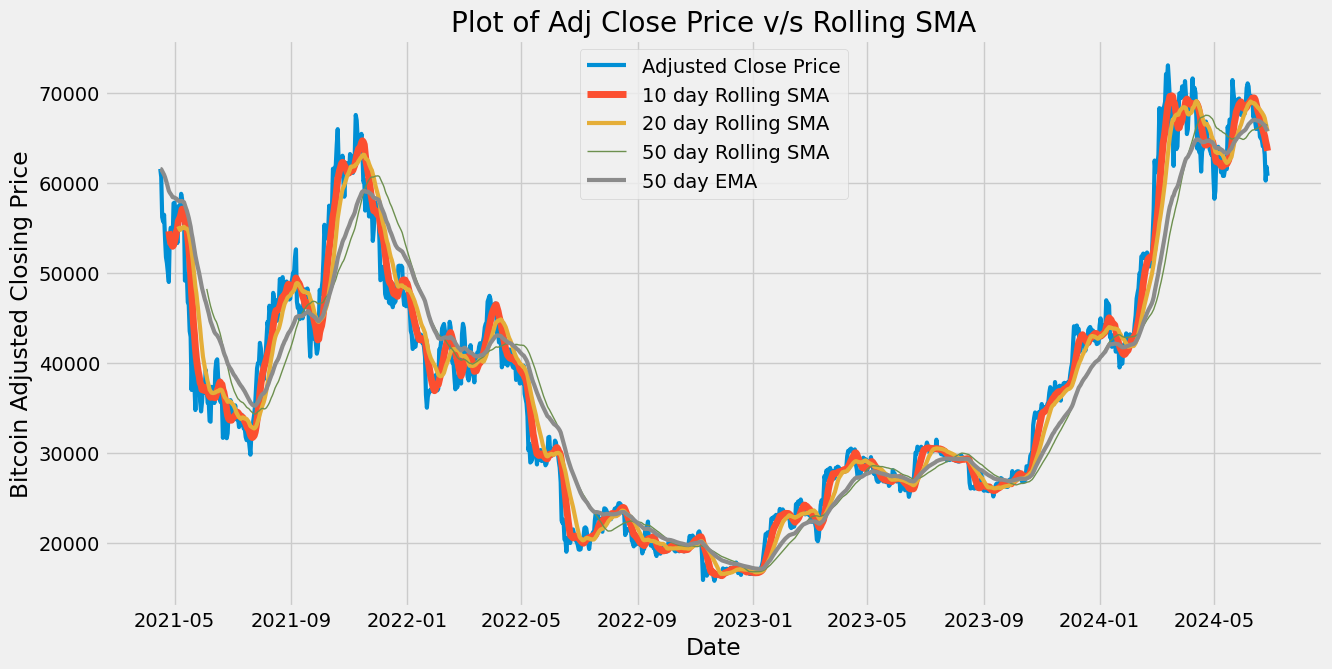

In [21]:
#Plotting 'Adj Close' Price and Rolling SMA and EMA lines
plt.figure(figsize = (14,7))
plt.plot(df_btc['Adj Close'],label='Adjusted Close Price',linewidth=3)
plt.plot(df_btc['SMA_10'],label='10 day Rolling SMA',linewidth=5)
plt.plot(df_btc['SMA_20'],label='20 day Rolling SMA',linewidth=3)
plt.plot(df_btc['SMA_50'],label='50 day Rolling SMA',linewidth=1)
plt.plot(df_btc['EMA_50'],label='50 day EMA',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Bitcoin Adjusted Closing Price')
plt.title('Plot of Adj Close Price v/s Rolling SMA')
plt.legend()

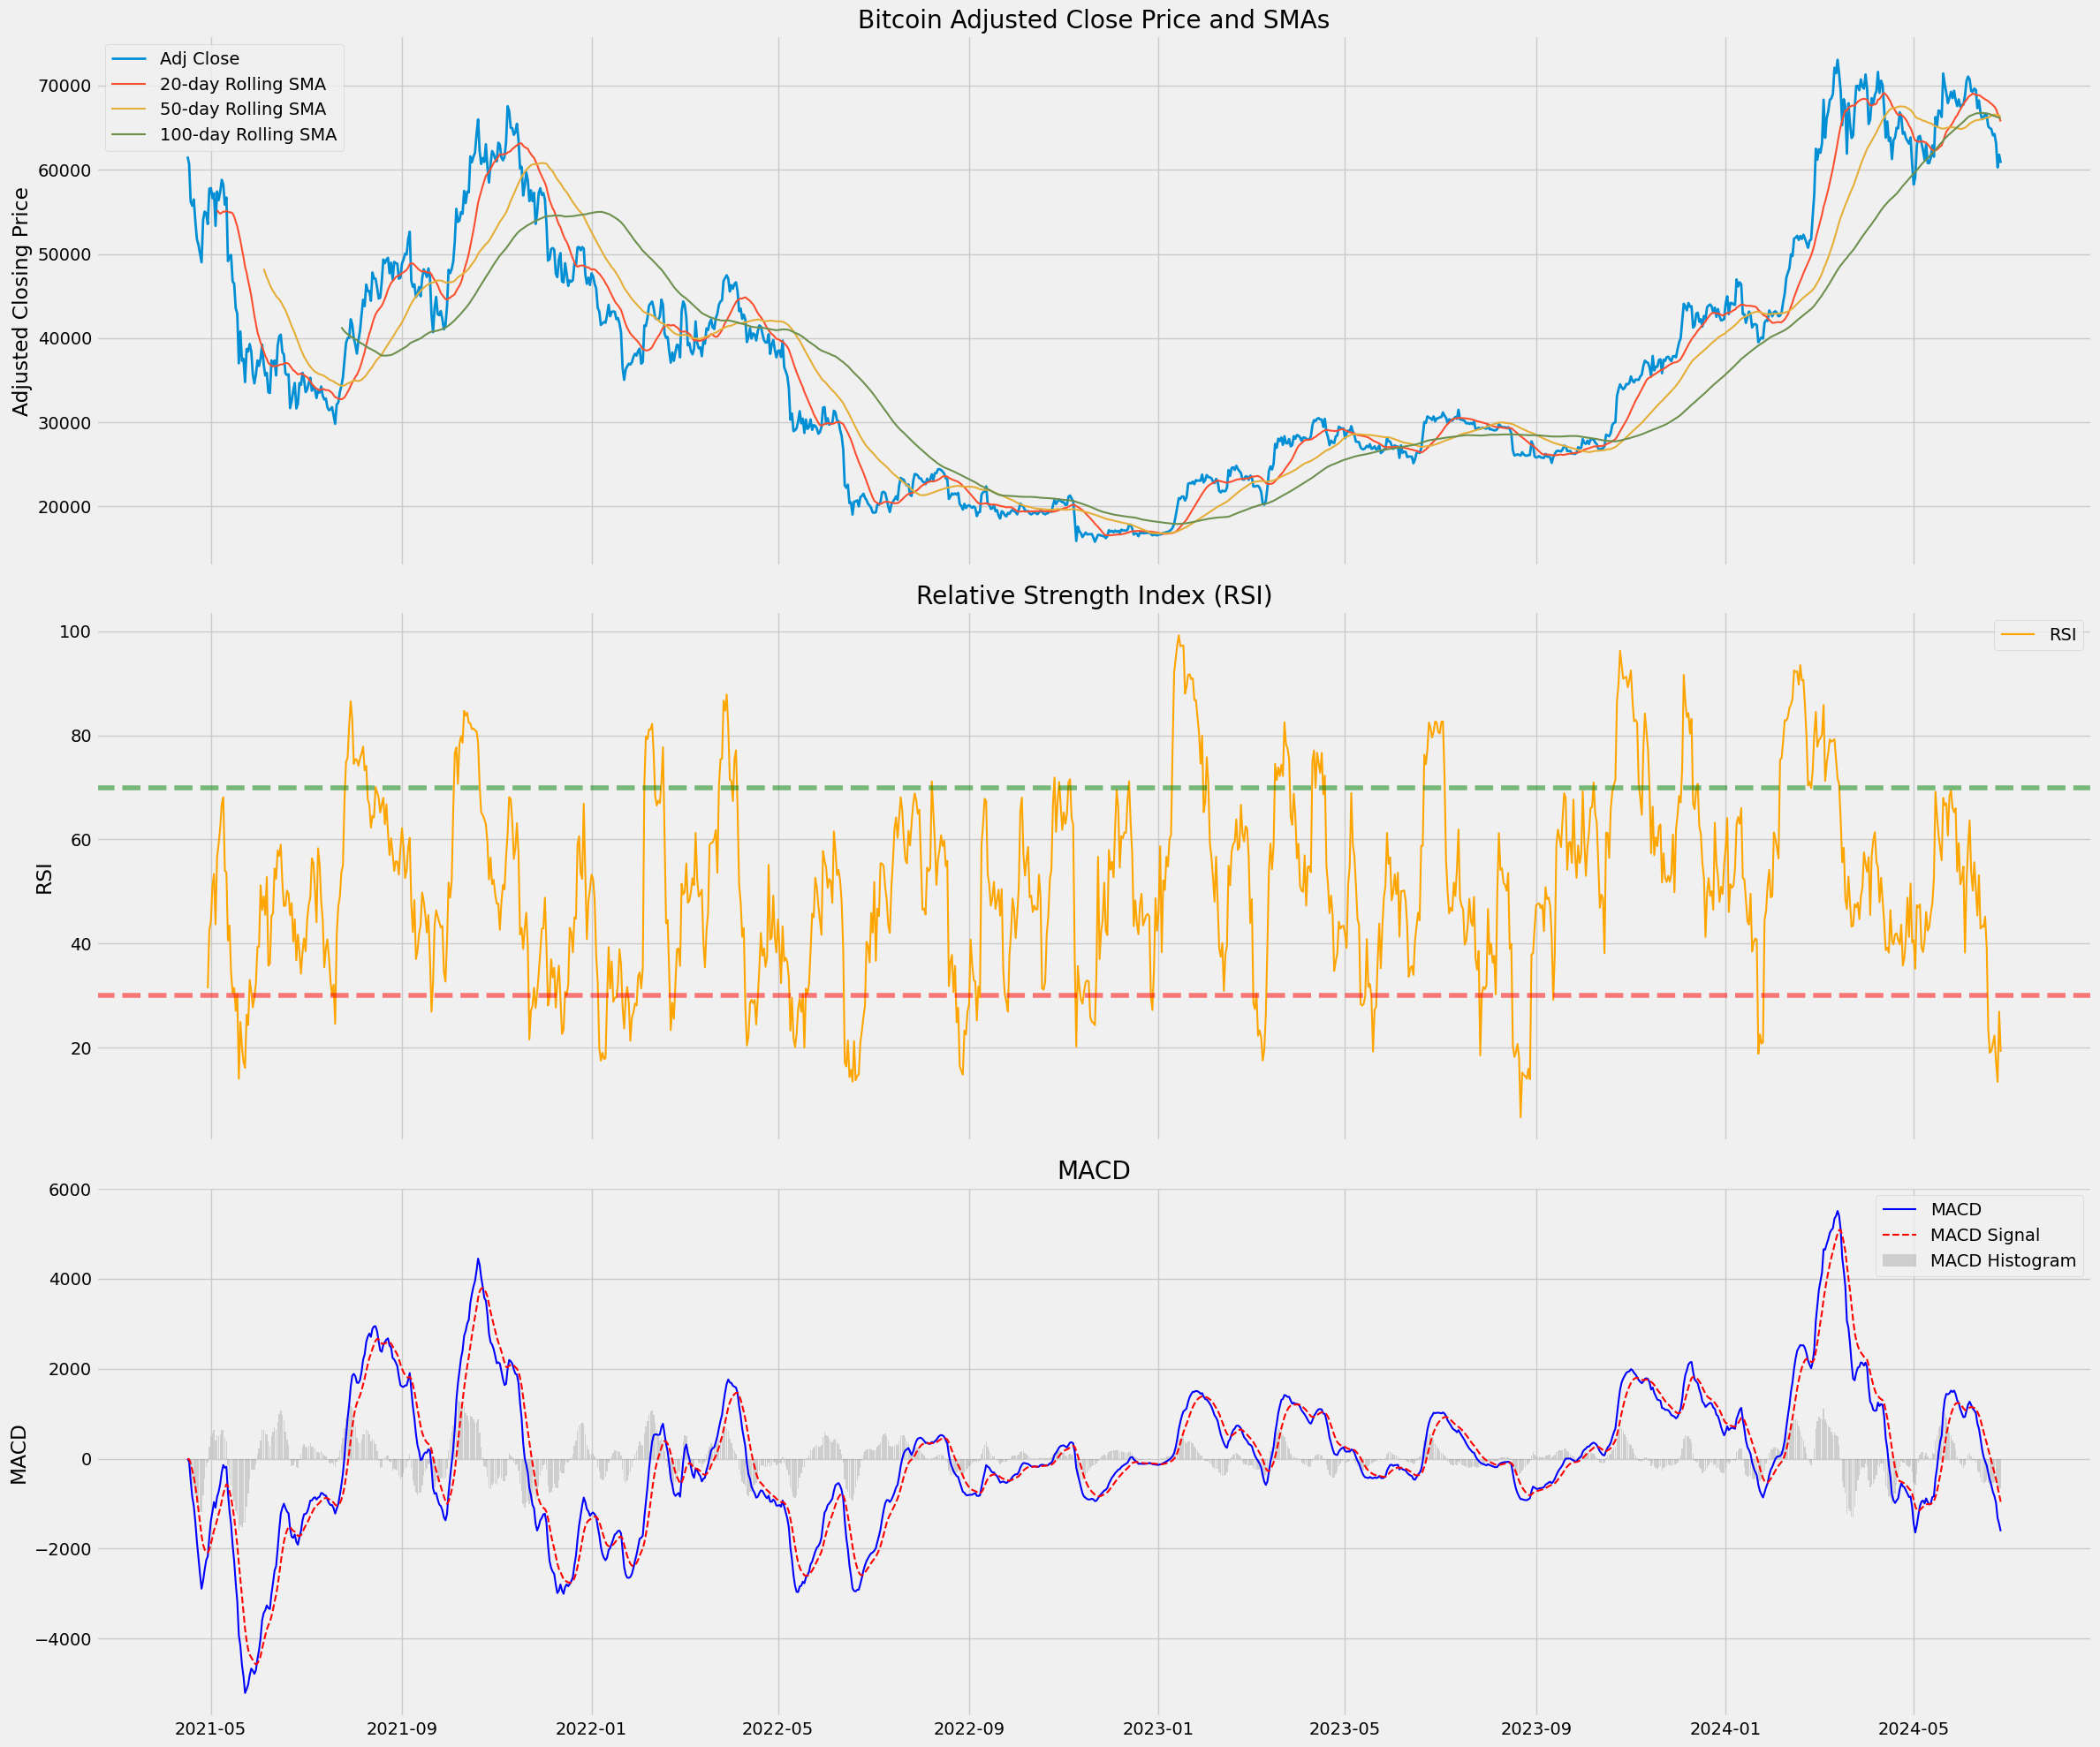

In [34]:
# Plotting Moving averages and MACD signal
# to get comprehensive view of Coinbase price trends, volatility, and potential market reversal points

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

# Plotting 'Adj Close' Price vs SMA lines on the first subplot
ax1.plot(df_btc['Adj Close'], label='Adj Close', linewidth=2)
ax1.plot(df_btc['SMA_20'], label='20-day Rolling SMA', linewidth=1.5)
ax1.plot(df_btc['SMA_50'], label='50-day Rolling SMA', linewidth=1.5)
ax1.plot(df_btc['SMA_100'], label='100-day Rolling SMA', linewidth=1.5)
ax1.set_title('Bitcoin Adjusted Close Price and SMAs')
ax1.set_ylabel('Adjusted Closing Price')
ax1.legend()

# Plotting RSI on the second subplot
ax2.plot(df_btc['RSI'], label='RSI', color='orange', linewidth=1.5)
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_ylabel('RSI')
ax2.axhline(30, linestyle='--', alpha=0.5, color='red')
ax2.axhline(70, linestyle='--', alpha=0.5, color='green')
ax2.legend()

# Plotting MACD on the third subplot
ax3.plot(df_btc['MACD'], label='MACD', color='blue', linewidth=1.5)
ax3.plot(df_btc['MACD_Signal'], label='MACD Signal', color='red', linestyle='--', linewidth=1.5)
ax3.bar(df_btc.index, df_btc['MACD_Hist'], label='MACD Histogram', color='grey', alpha=0.3)
ax3.set_title('MACD')
ax3.set_ylabel('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

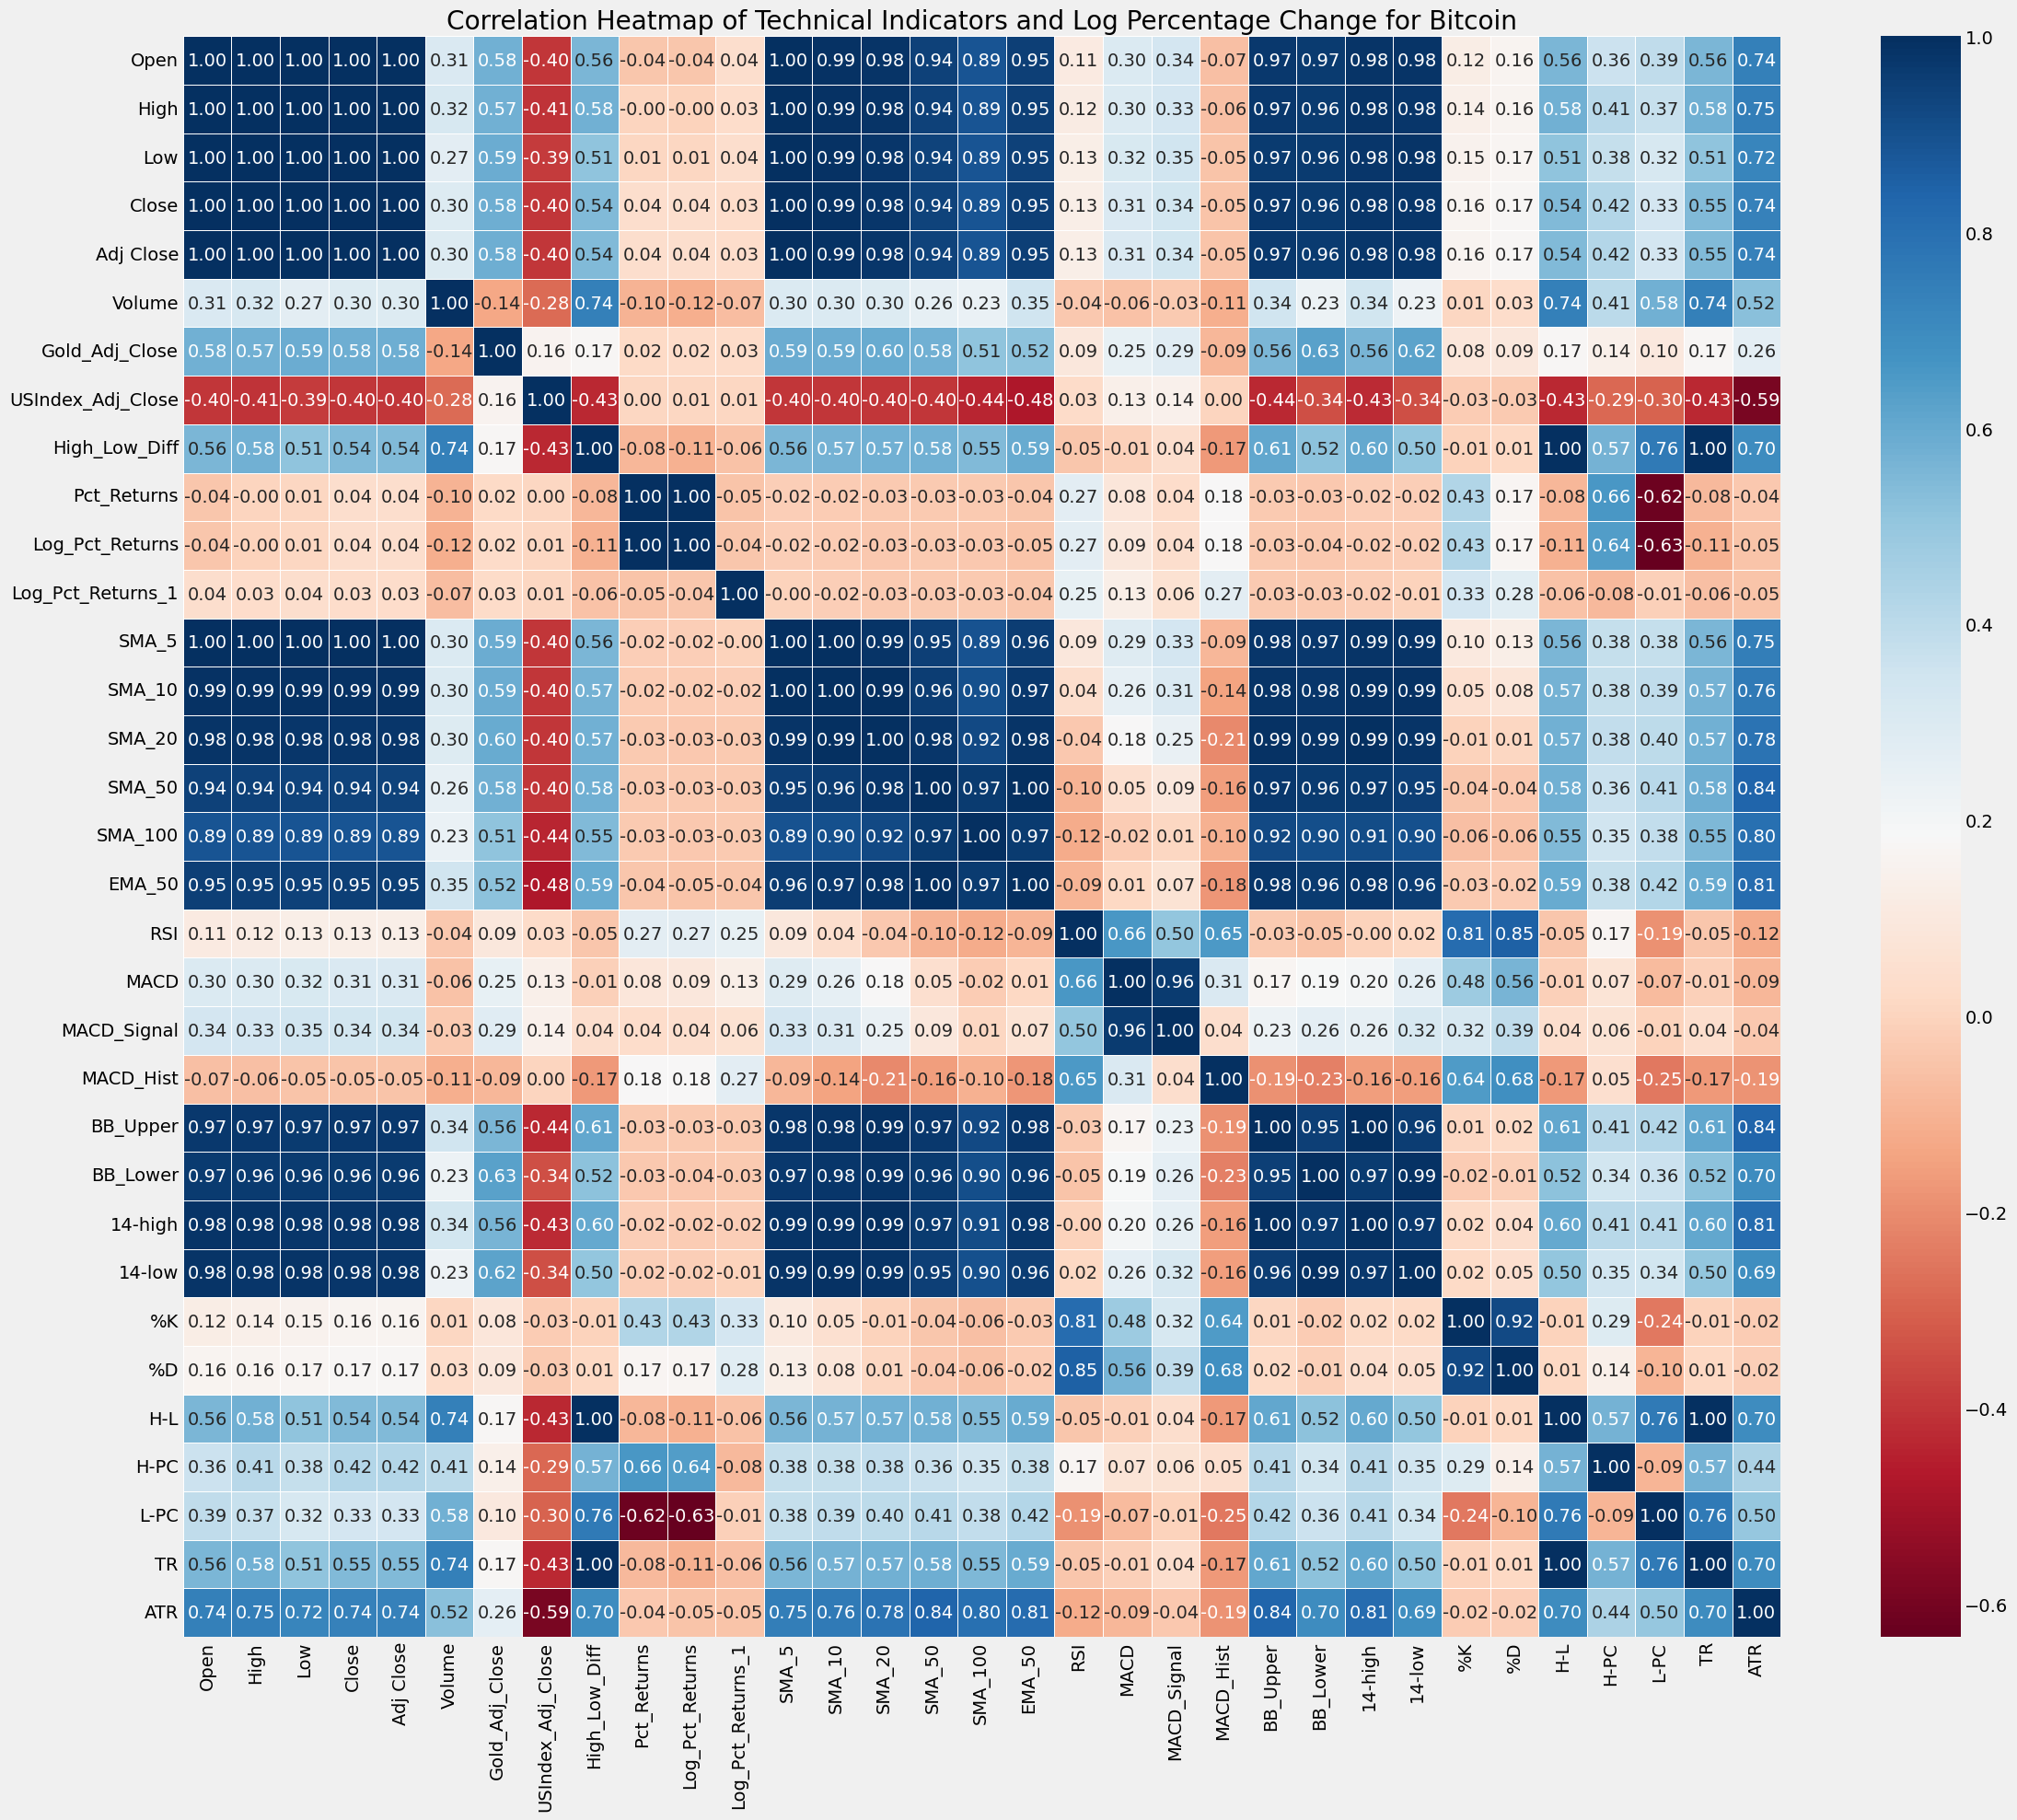

In [23]:
# Correlation between technical indiactors and log percentage change
# Compute correlation matrix
corr_matrix = df_btc.corr()

# Create a heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Technical Indicators and Log Percentage Change for Bitcoin')
plt.tight_layout()
plt.show()


#### Economic Indicators

In [24]:
# Fetch Real disposable Income data(Monthly) from FRED using pandas_datareader
Real_Disp_Inc_Mon = pdr.get_data_fred('DSPIC96', start=start_date, end=end_date)
Real_Disp_Inc_df = Real_Disp_Inc_Mon.resample('D').ffill()
Real_Disp_Inc_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Real_Disp_Inc_df.index = pd.to_datetime(Real_Disp_Inc_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_btc.join(Real_Disp_Inc_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)
merged_df


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,TR,ATR,DSPIC96,FEDFUNDS,GDPC1,UNRATE,UMCSENT,CPILFESL,PPIACO,WM2NS
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-24,33593.730469,34490.390625,33424.859375,34292.445312,34292.445312,21664706865,1801.400024,92.910004,1065.531250,0.021169,...,1065.531250,1445.120117,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20569.9
2021-07-25,34290.292969,35364.925781,33881.835938,35350.187500,35350.187500,20856685287,1801.400024,92.910004,1483.089844,0.030845,...,1483.089844,1462.629046,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20569.9
2021-07-26,35384.031250,40499.675781,35287.312500,37337.535156,37337.535156,51022126212,1798.699951,92.650002,5212.363281,0.056219,...,5212.363281,1699.594448,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
2021-07-27,37276.035156,39406.941406,36441.726562,39406.941406,39406.941406,35097370560,1799.500000,92.430000,2965.214844,0.055424,...,2965.214844,1835.275391,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
2021-07-28,39503.187500,40816.070312,38862.437500,39995.906250,39995.906250,38702404695,1799.500000,92.320000,1953.632812,0.014946,...,1953.632812,1873.229632,16836.1,0.10,21483.083,5.4,81.2,278.612,231.850,20521.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,2073.899902,101.230003,1486.230469,-0.018760,...,1486.230469,1342.053571,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,2062.399902,101.330002,1700.261719,-0.012397,...,1700.261719,1363.868304,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945,2062.399902,101.330002,1027.898438,0.001366,...,1027.898438,1370.015904,16889.2,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


In [25]:
# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Low', 'Volume',
    'High_Low_Diff', 'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR',
    'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
    'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS'
]

# Number of lagged versions to create
num_lags = 5

# Dictionary to store the shifted columns
shifted_columns = {}

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):  
        shifted_columns[f'{column}_{lag}'] = merged_df[column].shift(lag)

# Create a DataFrame from the shifted columns
shifted_df = pd.DataFrame(shifted_columns)

# Concatenate the shifted columns to the original DataFrame
merged_df = pd.concat([merged_df, shifted_df], axis=1)

# Drop rows with any NaN values
merged_df.dropna(inplace=True)

merged_df

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,High_Low_Diff,Pct_Returns,...,PPIACO_1,PPIACO_2,PPIACO_3,PPIACO_4,PPIACO_5,WM2NS_1,WM2NS_2,WM2NS_3,WM2NS_4,WM2NS_5
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-29,39995.453125,40593.070312,39352.058594,40008.421875,40008.421875,27167146027,1831.199951,91.860001,1241.011719,0.000313,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20569.9,20569.9
2021-07-30,40027.484375,42235.546875,38397.355469,42235.546875,42235.546875,33072782960,1812.599976,92.169998,3838.191406,0.055666,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20569.9
2021-07-31,42196.304688,42231.449219,41110.832031,41626.195312,41626.195312,25802845343,1812.599976,92.169998,1120.617188,-0.014427,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
2021-08-01,41460.843750,42541.679688,39540.941406,39974.894531,39974.894531,26688438115,1812.599976,92.169998,3000.738281,-0.039670,...,231.850,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
2021-08-02,39907.261719,40419.179688,38746.347656,39201.945312,39201.945312,25595265436,1818.099976,92.050003,1672.832031,-0.019336,...,233.415,231.850,231.850,231.850,231.850,20521.9,20521.9,20521.9,20521.9,20521.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,2073.899902,101.230003,1486.230469,-0.018760,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20875.3,20875.3
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,2062.399902,101.330002,1700.261719,-0.012397,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20901.5,20875.3
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945,2062.399902,101.330002,1027.898438,0.001366,...,249.866,249.866,249.866,249.866,249.866,20901.5,20901.5,20901.5,20901.5,20901.5


In [26]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3', 
            'Volume_4', 'Open_4', 'High_4', 'Low_4', 
            'High_Low_Diff_4', 'Gold_Adj_Close_4','USIndex_Adj_Close_4', 
            'Volume_5', 'Open_5', 'High_5', 'Low_5', 
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'SMA_5_4', 'SMA_10_4', 'SMA_20_4', 'SMA_50_4','SMA_100_4',
            'EMA_50_4', 'RSI_4', 'MACD_4', 'MACD_Signal_4',
            'MACD_Hist_4', 'BB_Upper_4', 'BB_Lower_4', '%K_4', '%D_4', 'ATR_4',
            'SMA_5_5', 'SMA_10_5', 'SMA_20_5', 'SMA_50_5','SMA_100_5',
            'EMA_50_5', 'RSI_5', 'MACD_5', 'MACD_Signal_5',
            'MACD_Hist_5', 'BB_Upper_5', 'BB_Lower_5', '%K_5', '%D_5', 'ATR_5',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3',
            'DSPIC96_4', 'FEDFUNDS_4', 'GDPC1_4', 'UNRATE_4', 
            'UMCSENT_4', 'CPILFESL_4', 'PPIACO_4', 'WM2NS_4',
            'DSPIC96_5', 'FEDFUNDS_5', 'GDPC1_5', 'UNRATE_5', 
            'UMCSENT_5', 'CPILFESL_5', 'PPIACO_5', 'WM2NS_5'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define models to evaluate
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  
        ('model', model)            
    ])
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    # Store results in dictionary
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Linear:
Training MSE: 0.0001 (Std Dev: 0.0000)
Test MSE: 1482523997015842304.0000 (Std Dev: 4447571991047527424.0000)
Training RMSE: 0.0065 (Std Dev: 0.0032)
Test RMSE: 385035582.4188 (Std Dev: 1155106747.1395)
Training MAE: 0.0044 (Std Dev: 0.0022)
Test MAE: 251631705.5351 (Std Dev: 754895116.5148)
Training R2: 0.9513 (Std Dev: 0.0319)
Test R2: -1144510701823043698688.0000 (Std Dev: 3433532105469131227136.0000)

Lasso:
Training MSE: 0.0011 (Std Dev: 0.0001)
Test MSE: 0.0009 (Std Dev: 0.0004)
Training RMSE: 0.0338 (Std Dev: 0.0019)
Test RMSE: 0.0281 (Std Dev: 0.0076)
Training MAE: 0.0243 (Std Dev: 0.0022)
Test MAE: 0.0194 (Std Dev: 0.0057)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0347 (Std Dev: 0.0382)

Ridge:
Training MSE: 0.0003 (Std Dev: 0.0000)
Test MSE: 0.0009 (Std Dev: 0.0010)
Training RMSE: 0.0163 (Std Dev: 0.0009)
Test RMSE: 0.0266 (Std Dev: 0.0151)
Training MAE: 0.0114 (Std Dev: 0.0007)
Test MAE: 0.0202 (Std Dev: 0.0132)
Training R2: 0.7645 (Std Dev: 0.0278)
Test R2:

#### Hypertuning best performing model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.67308e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.28595e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.16302e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Training MSE: 0.0001
Training MSE Std Dev: 0.0000
Test MSE: 0.0002
Test MSE Std Dev: 0.0002
Training RMSE: 0.0088
Training RMSE Std Dev: 0.0020
Test RMSE: 0.0115
Test RMSE Std Dev: 0.0057
Training MAE: 0.0055
Training MAE Std Dev: 0.0010
Test MAE: 0.0081
Test MAE Std Dev: 0.0046
Training R2: 0.9276
Training R2 Std Dev: 0.0306
Test R2: 0.8101
Test R2 Std Dev: 0.1574


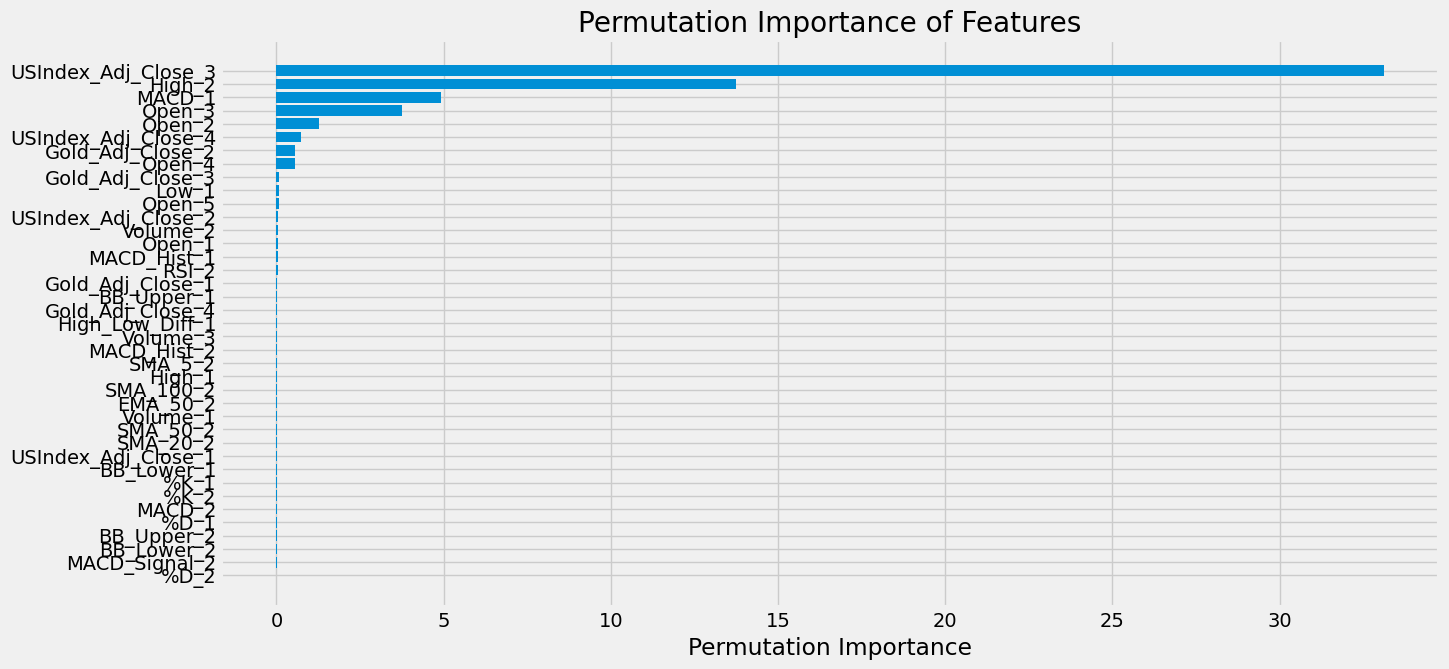

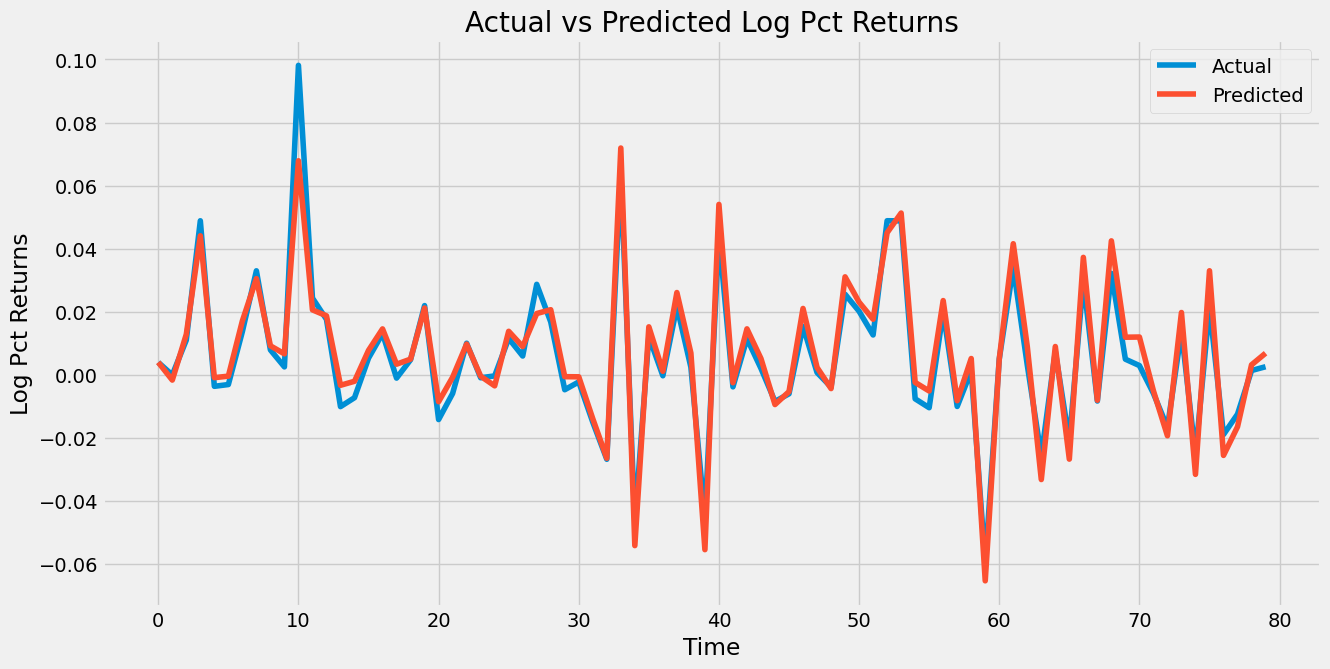

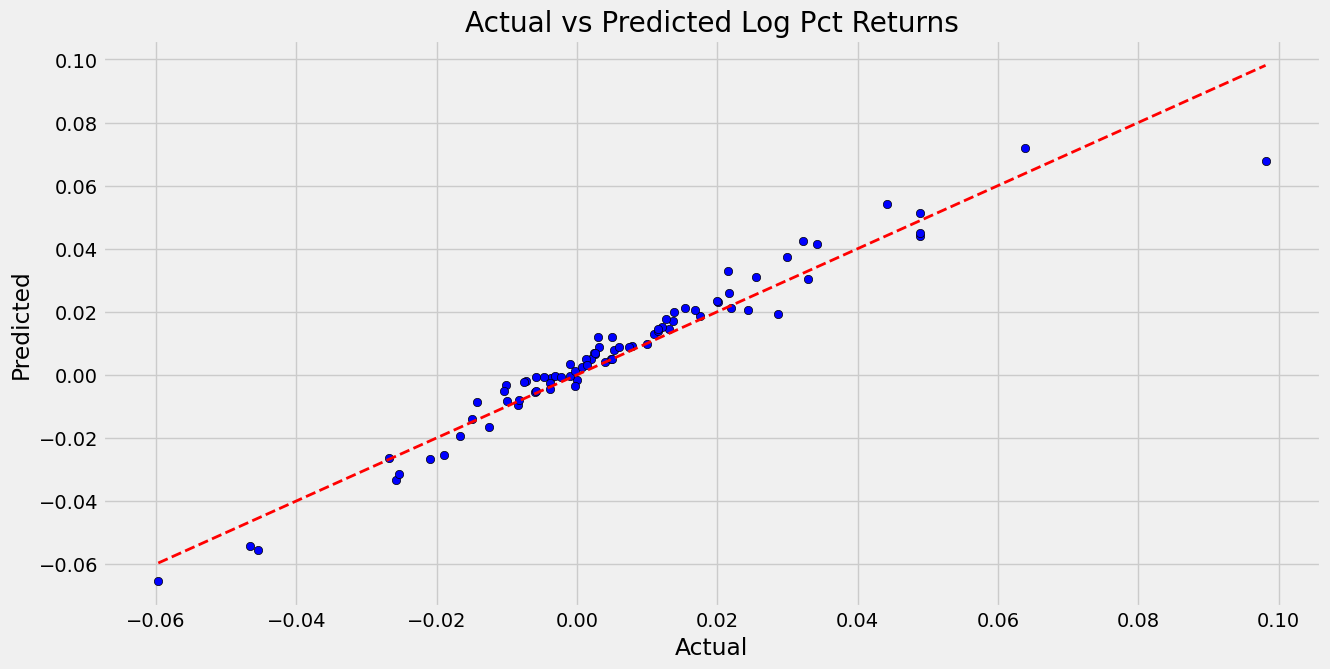

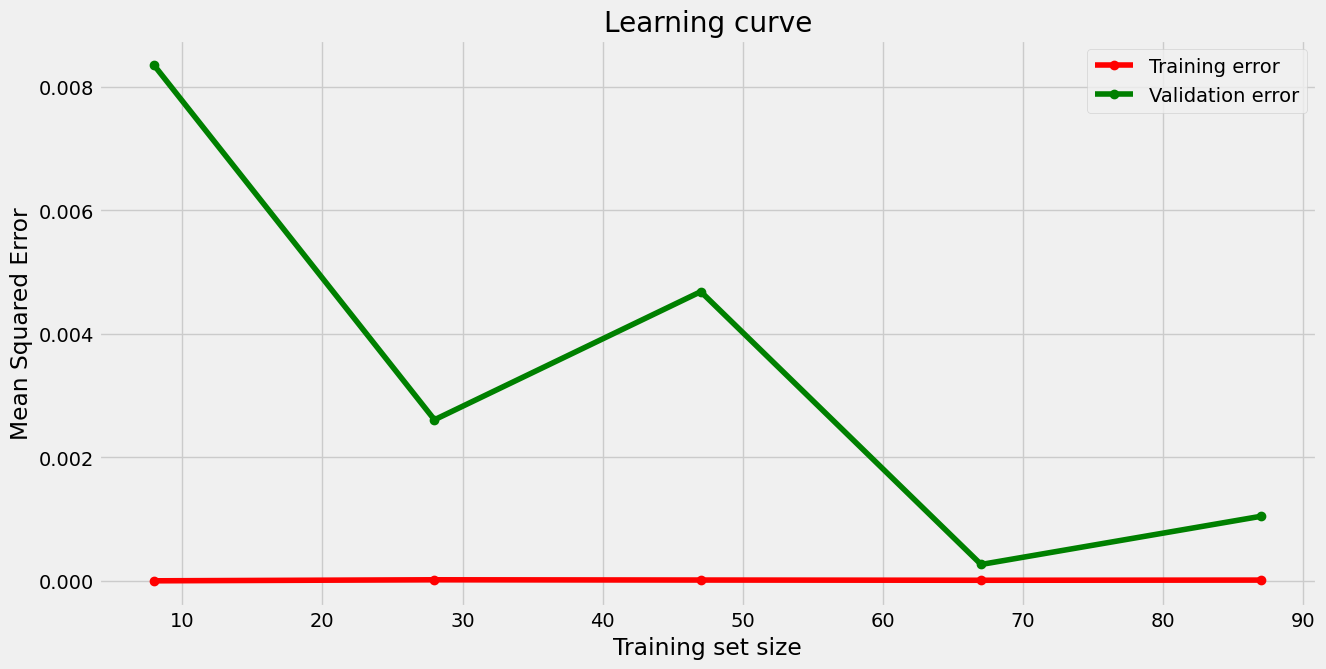

In [36]:
# Best performing model among Linear, Lasso, Ridge, Random Forest, Gradient Boost, XGBoost and SVR 
# is Ridge Regression Model

# Ridge Regression Model

np.random.seed(42)

features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 
             'Gold_Adj_Close_2','USIndex_Adj_Close_2', 
            'Volume_3', 'Open_3',  
             'Gold_Adj_Close_3','USIndex_Adj_Close_3', 'Open_4', 
             'Gold_Adj_Close_4','USIndex_Adj_Close_4', 'Open_5','MACD_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1',
            'SMA_5_2',  'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'DSPIC96', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1', 'UNRATE_2', 
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 'WM2NS_1',
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2', 'UNRATE_2', 
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 'WM2NS_2',
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3', 'UNRATE_3', 
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 'WM2NS_3',
            
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply Recursive Feature Elimination (RFE)
estimator = Ridge()
rfe = RFE(estimator, n_features_to_select=39, step=1)
X_rfe = rfe.fit_transform(X, y)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_rfe)

# Define the range of alpha values to test
alpha_values = [1e-4, 1e-3, 1e-2, 0.1, 1.0, 10.0, 100.0]

# Create a parameter grid
param_grid = {'alpha': alpha_values}

# Initialize Ridge regression model
model = Ridge()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    model = grid_search.best_estimator_

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()
plt.figure(figsize=(14, 7))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()


# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(14, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

Training MSE: 0.0000
Training MSE Std Dev: 0.0000
Test MSE: 0.0003
Test MSE Std Dev: 0.0002
Training RMSE: 0.0039
Training RMSE Std Dev: 0.0023
Test RMSE: 0.0165
Test RMSE Std Dev: 0.0046
Training MAE: 0.0030
Training MAE Std Dev: 0.0017
Test MAE: 0.0112
Test MAE Std Dev: 0.0039
Training R2: 0.9806
Training R2 Std Dev: 0.0185
Test R2: 0.6390
Test R2 Std Dev: 0.0646


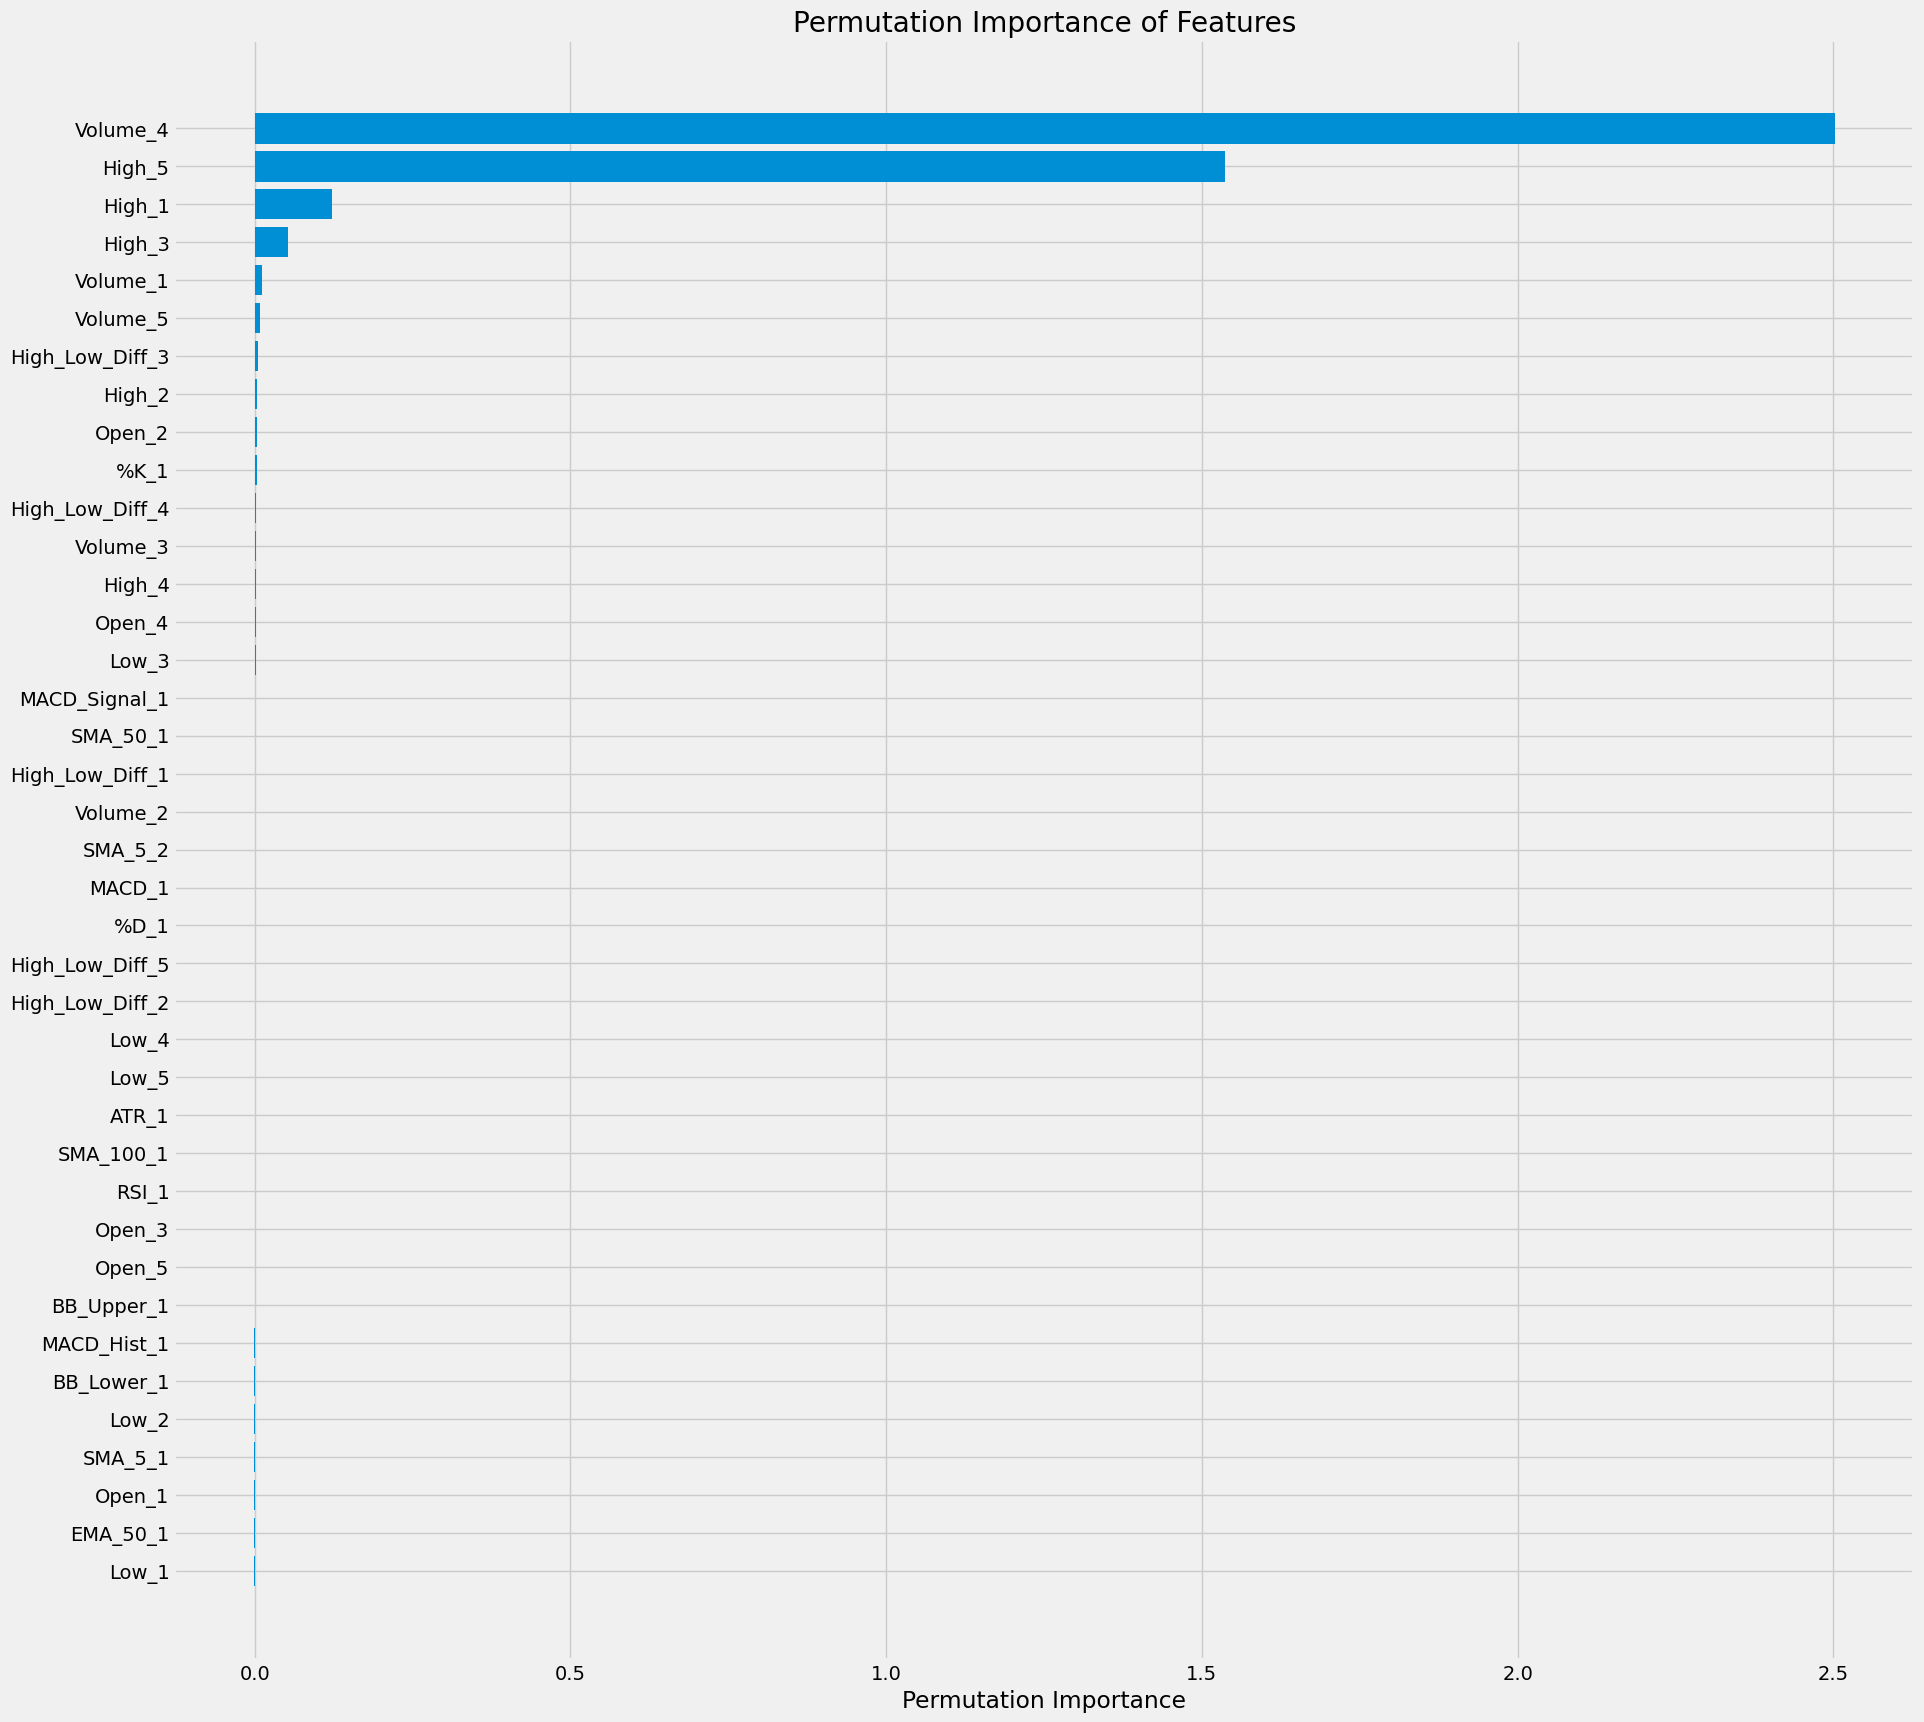

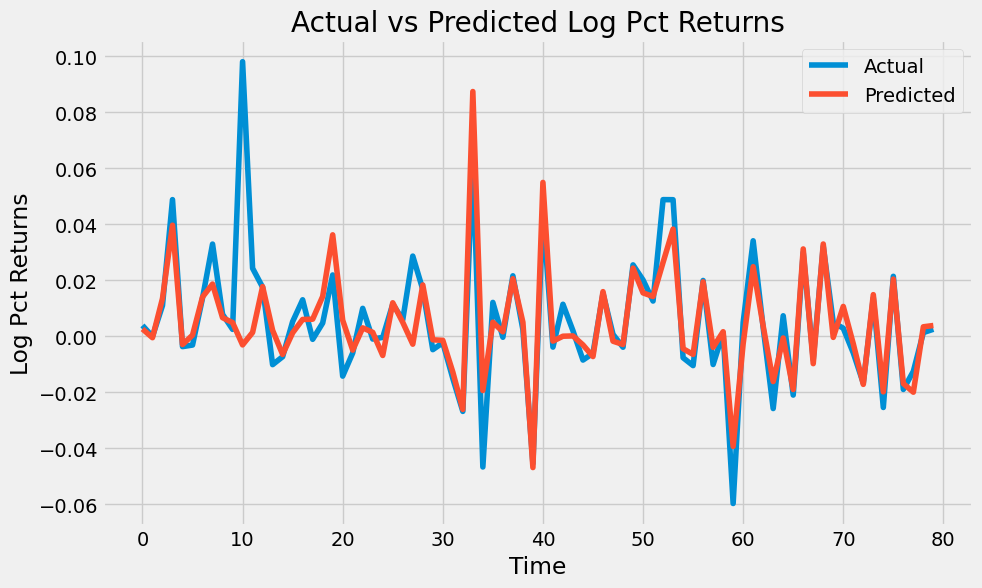

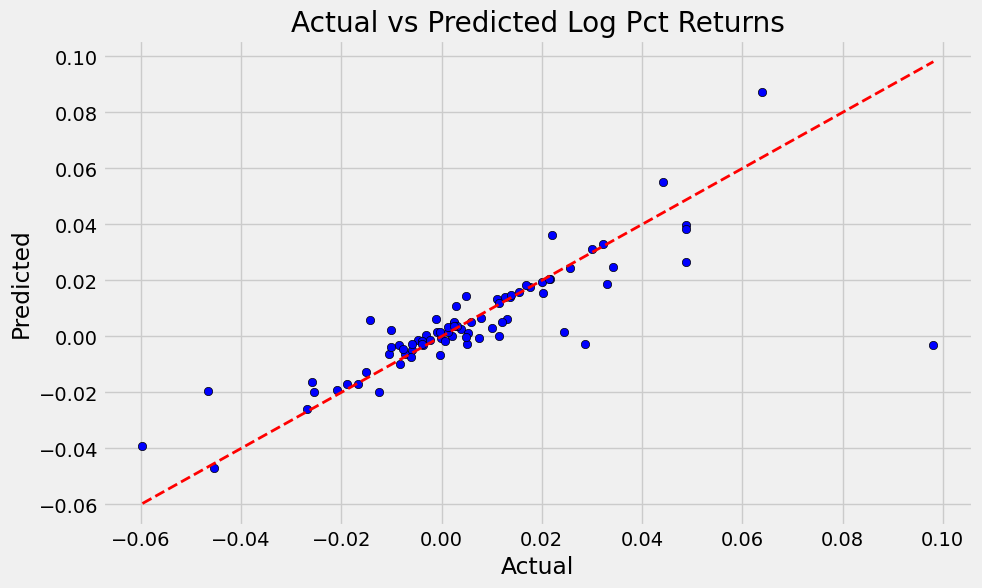

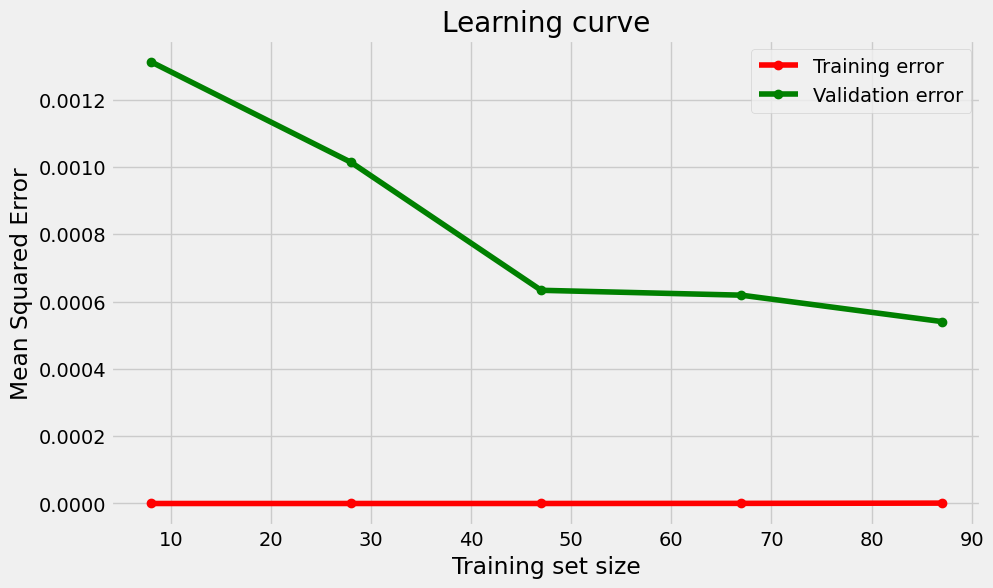

In [33]:
# Gradient Boosting Regression Model

np.random.seed(42)

features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'High_Low_Diff_1', 
            'Volume_2', 'Open_2', 'High_2', 'Low_2',
            'High_Low_Diff_2', 
            'Volume_3', 'Open_3', 'High_3', 'Low_3', 
            'High_Low_Diff_3',  
            'Volume_4', 'Open_4', 'High_4', 'Low_4', 
            'High_Low_Diff_4', 
            'Volume_5', 'Open_5', 'High_5', 'Low_5', 
            'High_Low_Diff_5', 
            'SMA_5_1', 'SMA_50_1', 'SMA_100_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2','SMA_100_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'SMA_5_3', 'SMA_10_3', 'SMA_20_3', 'SMA_50_3','SMA_100_3',
            'EMA_50_3', 'RSI_3', 'MACD_3', 'MACD_Signal_3',
            'MACD_Hist_3', 'BB_Upper_3', 'BB_Lower_3', '%K_3', '%D_3', 'ATR_3',
            'SMA_5_4', 'SMA_10_4', 'SMA_20_4', 'SMA_50_4','SMA_100_4',
            'EMA_50_4', 'RSI_4', 'MACD_4', 'MACD_Signal_4',
            'MACD_Hist_4', 'BB_Upper_4', 'BB_Lower_4', '%K_4', '%D_4', 'ATR_4',
            'SMA_5_5', 'SMA_10_5', 'SMA_20_5', 'SMA_50_5','SMA_100_5',
            'EMA_50_5', 'RSI_5', 'MACD_5', 'MACD_Signal_5',
            'MACD_Hist_5', 'BB_Upper_5', 'BB_Lower_5', '%K_5', '%D_5', 'ATR_5',
            'DSPIC96', 'FEDFUNDS', 'GDPC1',  
            'UMCSENT', 'CPILFESL', 'PPIACO', 
            'DSPIC96_1', 'FEDFUNDS_1', 'GDPC1_1',  
            'UMCSENT_1', 'CPILFESL_1', 'PPIACO_1', 
            'DSPIC96_2', 'FEDFUNDS_2', 'GDPC1_2',  
            'UMCSENT_2', 'CPILFESL_2', 'PPIACO_2', 
            'DSPIC96_3', 'FEDFUNDS_3', 'GDPC1_3',  
            'UMCSENT_3', 'CPILFESL_3', 'PPIACO_3', 
            'DSPIC96_4', 'FEDFUNDS_4', 'GDPC1_4', 
            'UMCSENT_4', 'CPILFESL_4', 'PPIACO_4',
            'DSPIC96_5', 'FEDFUNDS_5', 'GDPC1_5', 
            'UMCSENT_5', 'CPILFESL_5', 'PPIACO_5'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply Recursive Feature Elimination (RFE)
estimator = GradientBoostingRegressor()
rfe = RFE(estimator, n_features_to_select=39, step=1)
X_rfe = rfe.fit_transform(X, y)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_rfe)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize Gradient Boosting Regressor model
model = GradientBoostingRegressor(random_state=42)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    model = grid_search.best_estimator_

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(14, 7))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(14, 7))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(14, 7))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()